
# Advanced Machine Learning and Artificial Intelligence

# Project: Anomalies Detection using Autoencoders

## Notebook : Assignment



  .

In [98]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Project data and step-by-step instructions

The goal of this project is to to detect illegitimate connections in a computer network using an **autoencoder** 

## Data set description

Data set for this project is from [The Third International Knowledge Discovery and Data Mining Tools Competition](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) at KDD-99, The Fifth International Conference on Knowledge Discovery and Data Mining. File `kddCupTrain.csv` with the data necessary for this project contains only one of multiple types of attacks (see below).  

The competition [task](http://kdd.ics.uci.edu/databases/kddcup99/task.html) was building a network intrusion detector capable of distinguishing "bad" connections, called intrusions or attacks, from "good" normal connections. This database contains a variety of intrusions simulated in a military network environment.

The original KDD training dataset consists of approximately 4,900,000 single connection vectors each of which contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The simulated attacks fall in one of the following four categories:
1. Denial of Service Attack (DoS): is an attack in which the attacker makes some computing or memory resource too busy or too full to handle legitimate requests, or denies legitimate users access to a machine.
2. User to Root Attack (U2R): is a class in which the attacker starts out with access to a normal user account on the system (perhaps gained by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system.
3. Remote to Local Attack (R2L): occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine.
4. Probing Attack: is an attempt to gather information about a network of computers for the apparent purpose of circumventing its security controls.


Attacks contained in the dataset: 

Attack Category | Attack Type
--- | ---
DoS | back, land, neptune, <br>pod, smurf, teardrop
U2R | buffer_overflow, loadmodule, <br>perl, rootkit
R2L | ftp_write, guess_passwd, <br>imap, multihop, rhf, <br>spy, warezclient, warezmaster
Probe | portsweep, ipsweep, <br>satan, nmap


KDD-99 features can be classified into three groups:  
1) **Basic features**: this category encapsulates all the attributes that can be extracted from a TCP/IP connection. Most of these features leading to an implicit delay in detection.  
2) **Traffic features**: this category includes features that are computed with respect to a window interval and is divided into two groups:
* **"same host" features**: examine only the connections in the past 2 seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc.
* **"same service" features**: examine only the connections in the past 2 seconds that have the same service as the current connection.  

These two types of "traffic" features are called time-based as opposed to the following connection-based type. 

* **"connection-based" features**: there are several types of slow probing attacks that scan the hosts (or ports) using a much larger time interval than 2 seconds, for example, one in every minute. As a result, these attacks do not produce intrusion patterns with a time window of 2 seconds. To detect such attacks the “same host” and “same service” features are  recalculated but based on the connection window of 100 connections rather than a time window of 2 seconds. These features are called **connection-based traffic features**.  

3) **Content features**: unlike most of the DoS and Probing attacks, the R2L and U2R attacks don’t have any frequent sequential intrusion patterns. This is because the DoS and Probing attacks involve many connections to some host(s) in a very short period of time. Unlike them, the R2L and U2R attacks are embedded in the data portions of the packets, and normally involve only a single connection. To detect these kinds of attacks, one needs some features in order to look for suspicious behavior in the data portion, e.g., number of failed login attempts. These features are called **content features**.

#### Table 1: Basic features of individual TCP connections.
nn | feature name |	description |	type
--:|------------|-----------|-----------
0 | duration | length (number of seconds) of the connection |	continuous
1 | protocol_type |	type of the protocol, e.g. tcp, udp, etc. |	symbolic
2 | service |	network service on the destination, e.g., http, telnet, etc. |	symbolic
3 | flag |	normal or error status of the connection |	symbolic 
4 | src_bytes |	number of data bytes from source to destination |	continuous
5 | dst_bytes |	number of data bytes from destination to source |	continuous
6 | land |	1 if connection is from/to the same host/port; 0 otherwise |	binary
7 | wrong_fragment |	number of "wrong" fragments |	continuous
8 | urgent |	number of urgent packets |	continuous

#### Table 2: Content features within a connection suggested by domain knowledge.
nn | feature name |	description |	type
---:|------------ | ------------ | --------
9 | hot |	number of "hot" indicators |	continuous
10 | num_failed_logins |	number of failed login attempts |	continuous
11 | logged_in |	1 if successfully logged in; 0 otherwise |	binary
12 | num_compromised |	number of "compromised" conditions |	continuous
13 | root_shell |	1 if root shell is obtained; 0 otherwise |	binary
14 | su_attempted |	1 if "su root" command attempted; 0 otherwise |	binary
15 | num_root |	number of "root" accesses |	continuous
16 | num_file_creations |	number of file creation operations |	continuous
17 | num_shells |	number of shell prompts |	continuous
18 | num_access_files |	number of operations on access control files |	continuous
19 | num_outbound_cmds |	number of outbound commands in an ftp session |	continuous
20 | is_hot_login |	1 if the login belongs to the "hot" list; 0 otherwise |	binary
21 | is_guest_login |	1 if the login is a "guest" login; 0 otherwise |	binary

#### Table 3: Traffic features computed using a two-second time window.
nn  | feature name |	description |	type
---:|------------ | ------------ | --------
22 | count |	number of connections to the same host as the current connection in the past two seconds |	continuous
 | | Note: The following  features refer to these same-host connections.	|
23 | serror_rate |	% of connections that have "SYN" errors |	continuous
24 | rerror_rate |	% of connections that have "REJ" errors |	continuous
25 | same_srv_rate |	% of connections to the same service |	continuous
26 | diff_srv_rate |	% of connections to different services |	continuous
27 | srv_count |	number of connections to the same service as the current connection in the past two seconds |	continuous
 |  | Note: The following features refer to these same-service connections.	|
28 | srv_serror_rate |	% of connections that have "SYN" errors |	continuous
29 | srv_rerror_rate |	% of connections that have "REJ" errors |	continuous
30 | srv_diff_host_rate |	% of connections to different hosts |	continuous
31 | dst_host_count |	number of connections from the same address to the same host as the current connection in the past two seconds |	continuous
32 | dst_host_srv_count | number of connections from the same host to the same service as the current connection in the past two seconds | continuous
 |  | Note: The following features refer to these same-host and same-service connections.	|
33 | dst_host_same_srv_rate | |	continuous
34 | dst_host_diff_srv_rate | |	continuous
35 | dst_host_same_src_port_rate | |	continuous
36 | dst_host_srv_diff_host_rate | |	continuous
37 | dst_host_serror_rate | |	continuous
38 | dst_host_srv_serror_rate | |	continuous
39 | dst_host_rerror_rate | |	continuous
40 | dst_host_srv_rerror_rate | |	continuous

The attribute labeled **41** in the data set is the **"Class"** attribute which indicates whether a given instance is a normal connection instance or an attack.

## Project instructions

### 1. Preparing the data

#### 1.1. Reading data

Read the train dataset  `kddCupTrain.csv` from `kddCupData.zip` and check it for missing values.

In [14]:
kddCupTrain = pd.read_csv('data/kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9   10  11  12  13  14  15  16  \
0   0  tcp  http  SF  215  45076   0   0   0   0   0   1   0   0   0   0   0   
1   0  tcp  http  SF  162   4528   0   0   0   0   0   1   0   0   0   0   0   
2   0  tcp  http  SF  236   1228   0   0   0   0   0   1   0   0   0   0   0   

   17  18  19  20  21  22  23   24   25   26   27   28   29   30  31  32   33  \
0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0   0  0.0   
1   0   0   0   0   0   2   2  0.0  0.0  0.0  0.0  1.0  0.0  0.0   1   1  1.0   
2   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   2   2  1.0   

    34   35   36   37   38   39   40       41  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  normal.  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.5  0.0  0.0  0.0  0.0  0.0  normal.  


The train dataset contains instances of only two class types from the [original](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data: 
- "normal." - no attack
- "ipsweep." - a subtype of "probe" or Probing Attack type.  

In [15]:
kddCupTrain.iloc[:,-1].unique()

array(['normal.', 'ipsweep.'], dtype=object)

Rename column '41' to 'Class' and transform its values from symbolic type fo binary:  
- "normal." to 0  
- "ipsweep." to 1

In [16]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

Check counts of classes.

In [17]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


The dataset is highly imbalanced. Normal connections overwhelmingly outnumber fraudulent ones. 
This suggests using an autoencoder to detect attacks as rare deviations from normal.

#### 1.2. Remove the uninformative columns

Look at summaries of numeric features.

In [18]:
print(kddCupTrain.describe(percentiles=[]))

                   0             4             5              6         7  \
count  985262.000000  9.852620e+05  9.852620e+05  985262.000000  985262.0   
mean      215.078631  1.459258e+03  3.193730e+03       0.000007       0.0   
std      1343.633640  1.097984e+05  3.401613e+04       0.002665       0.0   
min         0.000000  0.000000e+00  0.000000e+00       0.000000       0.0   
50%         0.000000  2.300000e+02  4.060000e+02       0.000000       0.0   
max     58329.000000  8.958152e+07  1.173059e+07       1.000000       0.0   

                   8              9             10             11  \
count  985262.000000  985262.000000  985262.000000  985262.000000   
mean        0.000036       0.048908       0.000097       0.710185   
std         0.015897       0.926008       0.013058       0.453677   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
max        14.000000      77.000000       4.00

Note that some features are constant (min = max and std = 0.0). Such features are not necessary and need to be removed using

`kddCupTrain.drop(columnsList, axis=1, inplace=True)`.
  
#### 1.3. Transform symbolic features to "One Hot" columns

Transform character features "1", "2" and "3" into "One Hot" columns using `pandas.get_dummies()` as shown in the section above. 

As a result, the first two rows of `kddCupTrain` should look like this:  

|  0  |  4  |    5 | 6 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 20 | 21 | 22 | 23   
--|--
0 | 0 | 215 | 45076 | 0 | 0 | 0 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 | 1   
1 | 0 | 162 | 4528 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 2 | 2   

| 24 | 25 | 26 | 27 |  28 |  29  | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38
--|--
0|0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 |  0 |  0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0   
1|0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 |  1 |  1 | 1.0 | 0.0 | 1.0 | 0.0 | 0.0 | 0.0   

  | 39 | 40 | Class | 1_icmp | 1_tcp | 1_udp | 2_IRC | 2_X11 | 2_auth | 2_ctf
--|--
0 | 0.0 | 0.0 | 0 | 0 | 1 | 0 |  0  |    0  |     0  |    0   
1 | 0.0 | 0.0 | 0 | 0 | 1 | 0 |  0  |    0  |     0  |    0   

 | 2_domain | 2_domain_u | 2_eco_i | 2_ecr_i | 2_finger | 2_ftp | 2_ftp_data
 --|--
0  |   0  |    0  |   0  |  0  |   0  |    0   |   0   
1  |   0  |    0  |   0  |  0  |   0  |    0   |   0   

| 2_gopher | 2_http | 2_imap4 | 2_link | 2_mtp | 2_name | 2_ntp_u | 2_other 
--|--
0 |   0  |     1   |     0  |     0  |    0  |     0  |      0   |     0   
1 |   0  |     1   |     0  |     0  |    0  |     0  |      0   |     0   

| 2_pop_3 | 2_private | 2_red_i | 2_remote_job | 2_rje | 2_shell | 2_smtp | 2_ssh 
--|--
0 |       0 |         0 |       0 |            0 |     0 |       0 |      0 |     0   
1 |       0 |         0 |       0 |            0 |     0 |       0 |      0 |     0   

| 2_telnet | 2_tftp_u | 2_tim_i | 2_time | 2_urh_i | 2_urp_i | 2_whois | 3_OTH  
--|--
0 |        0 |     0 |       0 |      0 |       0 |       0 |       0 |     0   
1 |        0 |     0 |       0 |      0 |       0 |       0 |       0 |     0   

| 3_REJ | 3_RSTO | 3_RSTR | 3_S0 | 3_S1 | 3_S2 | 3_S3 | 3_SF | 3_SH  
--|--
0 |     0 |      0 |      0 |    0 |    0 |    0 |    0 |    1 |    0  
1 |     0 |      0 |      0 |    0 |    0 |    0 |    0 |    1 |    0  

In [27]:
#for col in kddCupTrain.columns:
#    print(col)
kddCupTrain.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40, 'Class'],
      dtype='object')

**Remove Columns with zero mean,max,min and SD**

In [28]:
columnsList=[7, 19]
kddCupTrain.drop(columnsList, axis=1, inplace=True)

**One Hot Encoding of categorial variables**

In [29]:
cat_variables = [1,2,3]

kddCupTrain = pd.get_dummies(kddCupTrain, columns = cat_variables)
kddCupTrain

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,2,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,3,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.00,4,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985257,0,212,2288,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,32,0.0,0.0,0.0,0.0,1.0,0.0,0.16,3,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
985258,0,219,236,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,33,0.0,0.0,0.0,0.0,1.0,0.0,0.15,4,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
985259,0,218,3610,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,34,0.0,0.0,0.0,0.0,1.0,0.0,0.15,5,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
985260,0,219,1234,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,35,0.0,0.0,0.0,0.0,1.0,0.0,0.14,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


After removing uninformative variables and replacing character variables with hot encoding the dataset contains 83 numeric features.

#### 1.4. Standardize the training dataset

Create a list of features, standardize the features columns using `sklearn.preprocessing.StandardScaler`.

**Further steps are similar to those covered in the notebook `MScA_32017_AMLAI_AE3_FraudDetection.ipynb`.**

#### 1.5. Split the data into train and test subsets 

Use `sklearn.model_selection.train_test_split()` function. Reserve 20% of data for the test data. Do not forget to set the parameter `stratify` to keep the class size ratio within each of data sets.

#### 1.6. Detach the labels from the train and the test datasets

#### 1.7. Separate the "normal" instances

An autoencoder will be trained to reconstruct class "normal". Separate the "normal" instances in both `train` and `test` datasets.

**Standardize the Dataset**

In [31]:
featuresList = [col for col in kddCupTrain if col != 'Class']
print('featuresList: ',featuresList)
kddCupTrain = kddCupTrain[featuresList + ['Class']]
print('\nTrain sample: \n')
kddCupTrain

featuresList:  [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, '1_icmp', '1_tcp', '1_udp', '2_IRC', '2_X11', '2_auth', '2_ctf', '2_domain', '2_domain_u', '2_eco_i', '2_ecr_i', '2_finger', '2_ftp', '2_ftp_data', '2_gopher', '2_http', '2_imap4', '2_link', '2_mtp', '2_name', '2_ntp_u', '2_other', '2_pop_3', '2_private', '2_red_i', '2_remote_job', '2_rje', '2_shell', '2_smtp', '2_ssh', '2_telnet', '2_tftp_u', '2_tim_i', '2_time', '2_urh_i', '2_urp_i', '2_whois', '3_OTH', '3_REJ', '3_RSTO', '3_RSTR', '3_S0', '3_S1', '3_S2', '3_S3', '3_SF', '3_SH']

Toy sample: 



,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH,Class
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,236,1228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,2,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,233,2032,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,3,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,239,486,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.00,4,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985257,0,212,2288,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,32,0.0,0.0,0.0,0.0,1.0,0.0,0.16,3,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
985258,0,219,236,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,33,0.0,0.0,0.0,0.0,1.0,0.0,0.15,4,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
985259,0,218,3610,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,34,0.0,0.0,0.0,0.0,1.0,0.0,0.15,5,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
985260,0,219,1234,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,35,0.0,0.0,0.0,0.0,1.0,0.0,0.14,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [32]:
scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTrain[featuresList]);

In [33]:
kddCupTrain[featuresList] = scaler.transform(kddCupTrain[featuresList])
kddCupTrain

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH,Class
0,-0.160072,-0.011332,1.231248,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.409932,-2.305156,-2.774254,-0.312768,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425,0
1,-0.160072,-0.011815,0.039225,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.343674,-0.413666,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.400319,-2.293712,0.505148,-0.312768,2.892443,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425,0
2,-0.160072,-0.011141,-0.057788,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.390706,-2.282268,0.505148,-0.312768,1.200921,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425,0
3,-0.160072,-0.011168,-0.034152,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.343674,-0.413666,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.381093,-2.270824,0.505148,-0.312768,0.625803,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425,0
4,-0.160072,-0.011114,-0.079601,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.287041,-0.367688,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.371480,-2.259

**Split Train dataset into train-test split**

In [54]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42

In [37]:
X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2,
                                   stratify=kddCupTrain['Class'], 
                                   random_state=RANDOM_SEED)

**Detach labels from the train and the test datasets and create y dataset** 

In [38]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 83) , shape Y (788209,)
Test: shape X (197053, 83) , shape Y (197053,)


**Select the "normal" transactions from the training data to train autoencoder on them.**

In [39]:
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


In [43]:
pd.value_counts(y_train, sort = True),pd.value_counts(y_test, sort = True)

(0    778224
 1      9985
 Name: Class, dtype: int64,
 0    194557
 1      2496
 Name: Class, dtype: int64)

In [44]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

### 2. Build the model

Follow the steps of  `MScA_32017_AMLAI_AE3_FraudDetection.ipynb` to create similar model for this project.

#### 2.1. select architecture of autoencoder

Try different numbers and dimentions of layers. Use `BatchNormalization` and `Dropout` layers to achieve better results.

#### 2.2. Fit the model

Fit autoencoder to the "normal" instances of the train dataset.  
Use `ModelCheckpoint` callback to save the best model to file:

`checkpointer = ModelCheckpoint(filepath="autoencoder.h5",
                               verbose=0,
                               save_best_only=True)`    
                               

In [46]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 42
encoder_dim = 21
input_dim

83

In [47]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

input_layer:  KerasTensor(type_spec=TensorSpec(shape=(None, 83), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
encoder1 KerasTensor(type_spec=TensorSpec(shape=(None, 42), dtype=tf.float32, name=None), name='dense/Tanh:0', description="created by layer 'dense'")
encoder2 KerasTensor(type_spec=TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
decoder1 KerasTensor(type_spec=TensorSpec(shape=(None, 42), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")
decoder2 KerasTensor(type_spec=TensorSpec(shape=(None, 83), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")


In [56]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 83)]              0         
_________________________________________________________________
dense (Dense)                (None, 42)                3528      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                903       
_________________________________________________________________
dense_2 (Dense)              (None, 42)                924       
_________________________________________________________________
dense_3 (Dense)              (None, 83)                3569      
Total params: 8,924
Trainable params: 8,924
Non-trainable params: 0
_________________________________________________________________


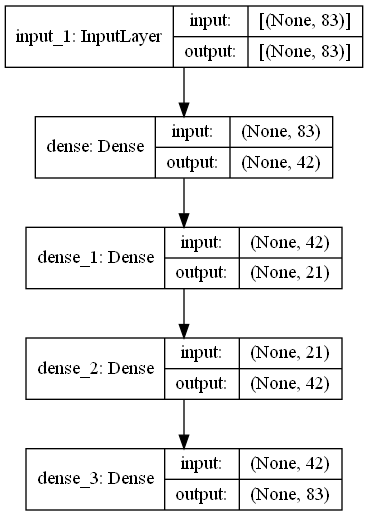

In [57]:
plot_model(autoencoder, show_shapes=True,show_layer_names=True)

Train the model for 100 epochs with a batch size of 32 samples and save the best performing model to a file using ModelCheckpoint provided by Keras.

Use the EarlyStopping callback that stops training when a monitored quantity has stopped improving.

In [58]:
## Not used
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc',multi_label=True),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
autoencoder = load_model('advml_ae_assignment_best_model.h5')

In [60]:
nb_epoch = 200
batch_size = 64

autoencoder.compile(optimizer=Adam(learning_rate=1e-4), 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="advml_ae_assignment_best_model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0) # 'patience' number of not improving epochs


Epoch 1/200
12160/12160 [==============================] - 30s 2ms/step - loss: 0.2187 - val_loss: 0.2427
Epoch 2/200
12160/12160 [==============================] - 29s 2ms/step - loss: 0.2171 - val_loss: 0.2417
Epoch 3/200
12160/12160 [==============================] - 30s 2ms/step - loss: 0.2144 - val_loss: 0.2393
Epoch 7/200
12160/12160 [==============================] - 29s 2ms/step - loss: 0.2137 - val_loss: 0.2389
Epoch 8/200
12160/12160 [==============================] - 32s 3ms/step - loss: 0.2132 - val_loss: 0.2383
Epoch 9/200
12160/12160 [==============================] - 41s 3ms/step - loss: 0.2130 - val_loss: 0.2380
Epoch 10/200
12160/12160 [==============================] - 38s 3ms/step - loss: 0.2123 - val_loss: 0.2375
Epoch 11/200
12160/12160 [==============================] - 39s 3ms/step - loss: 0.2119 - val_loss: 0.2369
Epoch 12/200
12160/12160 [==============================] - 41s 3ms/step - loss: 0.2114 - val_loss: 0.2368
Epoch 13/200
12160/12160 [=================

In [ ]:
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

    
                               
### 3. Evaluation

#### 3.1. Load the fitted autoencoder from file `"autoencoder.h5"`.

#### 3.2.  Reconstruction

Reconstruct the **test** dataset using the fitted autoencoder, calculate the **mean squared error** of the prediction.  

#### 3.3. Evaluate

Calculate MSE of each observation by averaging squared errors of reconstruction of all features in a row.  

Calculate ROC and AUC. Select appropriate quantile and calculate Accuracy and Cohen's Kappa.

Tune parameters of autoencoder to achieve better results (see Section 2.1.). Try to make AUC = 0.97 or better to get a good score.


In [61]:
autoencoder = load_model('advml_ae_assignment_best_model.h5')

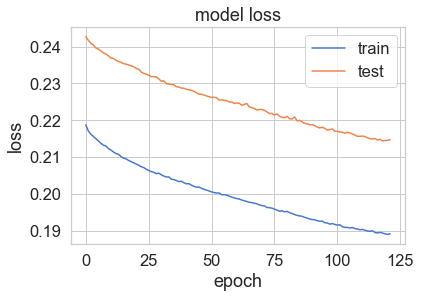

In [62]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [63]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((197053, 83), (197053, 83))

In [64]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
940543,0.128689,1
356110,0.028886,0
540178,0.000782,0
672514,0.005724,0
244980,0.001361,0


In [65]:
error_df.shape

(197053, 2)

In [66]:
error_df.reconstruction_error.describe()

count    197053.000000
mean          0.314770
std          30.884950
min           0.000058
25%           0.000844
50%           0.002608
75%           0.010863
max        8417.978720
Name: reconstruction_error, dtype: float64

Reconstruction errors for normal and fradulent transactions

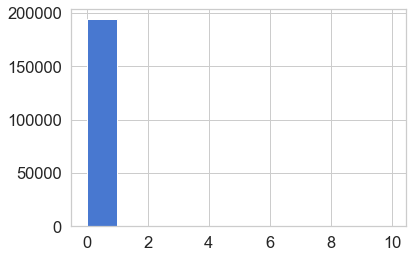

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

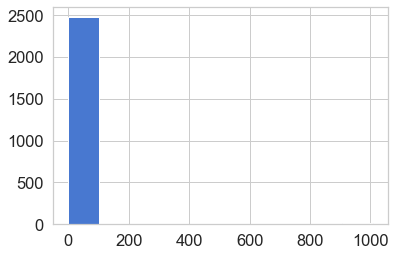

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

Errors of reconstruction of fraudulent data are much larger.

In [71]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

Calculate ROC curve and AUC:

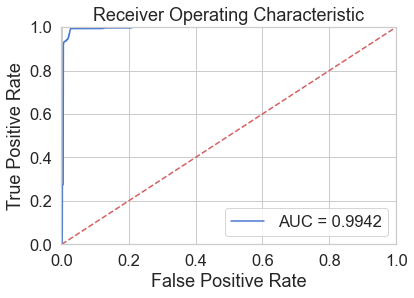

In [72]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

AUC for the autoencoder predictions is pretty high

### 4.Create submission

#### 4.1. Read test data

Read the **test** dataset from ['kddCupTest.csv'](kddCupTest.csv) and check it for missing values.  

In [84]:
kddCupTest = pd.read_csv('data/kddCupTest.csv', header=None)
print(kddCupTest.head(3))

   0    1        2   3     4      5   6   7   8   9   10  11  12  13  14  15  \
0   0  tcp     http  SF   230  10066   0   0   0   0   0   1   0   0   0   0   
1   0  udp  private  SF   105    145   0   0   0   0   0   0   0   0   0   0   
2   1  tcp     smtp  SF  1888    374   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21  22  23   24   25   26   27   28   29   30   31  \
0   0   0   0   0   0   0  19  20  0.0  0.0  0.0  0.0  1.0  0.0  0.1  255   
1   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   
2   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   

    32    33    34   35   36   37   38   39   40  
0  255  1.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  
1  227  0.89  0.01  0.0  0.0  0.0  0.0  0.0  0.0  
2  174  0.68  0.03  0.0  0.0  0.0  0.0  0.0  0.0  


Notice that there are no lables in the test dataset. The features columns are the same.

#### 4.2. Do "One hot" transformation of categorical features

Don't forget to make the features list exactly the same as in the **train** dataset.  


In [85]:
kddCupTest.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40],
           dtype='int64')

In [86]:
kddCupTest.drop(columnsList, axis=1, inplace=True)

In [87]:
kddCupTest = pd.get_dummies(kddCupTest, columns = cat_variables)
kddCupTest

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_Z39_50,2_auth,2_bgp,2_csnet_ns,2_ctf,2_daytime,2_discard,2_domain,2_domain_u,...,2_gopher,2_harvest,2_hostnames,2_http,2_http_2784,2_imap4,2_iso_tsap,2_link,2_mtp,2_name,2_netbios_dgm,2_netbios_ns,2_netbios_ssn,2_netstat,2_nntp,2_ntp_u,2_other,2_pm_dump,2_pop_2,2_pop_3,2_printer,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_sql_net,2_ssh,2_sunrpc,2_supdup,2_systat,2_telnet,2_tim_i,2_time,2_urh_i,2_urp_i,2_uucp,2_uucp_path,2_vmnet,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
0,0,230,10066,0,0,0,0,1,0,0,0,0,0,0,0,0,0,19,20,0.0,0.0,0.0,0.0,1.0,0.0,0.10,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,227,0.89,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1888,374,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,174,0.68,0.03,0.00,0.00,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,330,1477,0,0,0,0,1,0,0,0,0,0,0,0,0,0,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.00,94,255,1.00,0.00,0.01,0.03,0.01,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2625,146,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0.0,0.0,0.0,0.0,0.5,0.5,0.00,255,2,0.01,0.87,1.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.00,5,255,1.00,0.00,0.20,0.25,0.00,0.0,1.0,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
196553,0,146,5532,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,24,0.0,0.0,0.0,0.0,1.0,0.0,0.12,1,255,1.00,0.00,1.00,0.02,0.00,0.0,0.0,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
196554,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,245,0.96,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
196555,0,267,14496,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.0,0.0,0.00,56,255,1.00,0.00,0.02,0.03,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Add Missing colums of train set with zerop values and drop extract columns

In [88]:
missing_cols = set(kddCupTrain.columns) - set(kddCupTest.columns)
print('missing_cols: ',missing_cols)
for c in missing_cols:
    kddCupTest[c] = 0
kddCupTest = kddCupTest[kddCupTrain.columns].copy()

missing_cols:  {'3_SH', '2_tftp_u', 'Class'}


,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH,Class
0,0,230,10066,0,0,0,0,1,0,0,0,0,0,0,0,0,0,19,20,0.0,0.0,0.0,0.0,1.0,0.0,0.10,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,227,0.89,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1888,374,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,174,0.68,0.03,0.00,0.00,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,330,1477,0,0,0,0,1,0,0,0,0,0,0,0,0,0,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.00,94,255,1.00,0.00,0.01,0.03,0.01,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2625,146,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0.0,0.0,0.0,0.0,0.5,0.5,0.00,255,2,0.01,0.87,1.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.00,5,255,1.00,0.00,0.20,0.25,0.00,0.0,1.0,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
196553,0,146,5532,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,24,0.0,0.0,0.0,0.0,1.0,0.0,0.12,1,255,1.00,0.00,1.00,0.02,0.00,0.0,0.0,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
196554,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,245,0.96,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
196555,0,267,14496,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.0,0.0,0.00,56,255,1.00,0.00,0.02,0.03,0.00,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [89]:
kddCupTest = kddCupTest[featuresList]

In [91]:
kddCupTest.shape

(196557, 83)

 

#### 4.3. Standardize the test dataset

Use the scaler fitted to the training dataset.


In [92]:
kddCupTest[featuresList] = scaler.transform(kddCupTest[featuresList])
kddCupTest

<ipython-input-92-e513f7d7578f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kddCupTest[featuresList] = scaler.transform(kddCupTest[featuresList])
C:\Users\rsure\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,-0.160072,-0.011196,0.202030,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,0.619084,0.413940,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.136523,1.041395,0.613042,0.505148,-0.312768,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
1,-0.160072,-0.012334,-0.089626,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.486674,1.041395,0.292613,0.144414,-0.257618,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,-1.889026,2.036924,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,-1.300185,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,3.495030,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
2,-0.159328,0.003905,-0.082894,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.486674,1.041395,-0.313915,-0.544261,-0.147318,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,-1.300185,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,3.054411,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
3,-0.160072,-0.010285,-0.050468,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,0.052756,-0.091819,-0.054177,-0.065379,-0.244638,-0.247100,0.157516,-0.156700,-0.486674,-0.506306,0.613042,0.505148,-0.312768,-0.456771,-0.019122,0.281637,-0.067659,-0.256994,-0.255699,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.241500,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
4,1.793586,-0.011961,-0.090802,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.230408,-0.413666,-0.054177,-0.065379,-0.244638,-0.247100,-5.251171,4.122919,-0.486674,1.041395



#### 4.4. Make predictions and save the results to csv file.

Reconstruct the **kddCupTest** dataset, calculate **mean squared error** as reconstruction error.  
Save MSE to scv file. 

`result_df = pd.DataFrame({'reconstruction_error': testMSE})
 result_df.to_csv('filename.csv')`

The format should be as follows:  
  
,reconstruction_error  
0,0.019312
1,0.049165
2,0.084997 

In [93]:
kddCupTestPredictions = autoencoder.predict(kddCupTest)
kddCupTest.shape,kddCupTestPredictions.shape

((196557, 83), (196557, 83))

In [94]:
kddCupTestMSE = mean_squared_error(kddCupTest.transpose(), kddCupTestPredictions.transpose(),
                              multioutput='raw_values')


In [96]:
result_df = pd.DataFrame({'reconstruction_error': kddCupTestMSE})
result_df.head()

,reconstruction_error
0,0.000521
1,0.000404
2,0.003986
3,0.000908
4,0.012705


In [97]:
result_df.to_csv('advml_ae_assignment_recons_error.csv')

#### 4.5. Upload the results

Upload the saved file using [shiny test application](https://shiny.ilykei.com/courses/AdvancedML/AutoEncoder).
The uploaded results will be used for calculation of AUC. The goal for this project is to get AUC not less then 0.97.
